In [1]:
#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from joblib import parallel_backend
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.datasets import load_boston
data_dir='/home/ubuntu/cognition_iowa/data/'
results_dir='/home/ubuntu/cognition_iowa/results/' 


In [2]:
#load estimated SC and save in one .mat file for eFC prediction (Zijin's code)
nROIs=86
subj_id =  pd.read_csv(data_dir + 'final_subIDs.csv',header=None)[0]
sc = np.zeros([len(subj_id),3655])

for i in range(len(subj_id)):
    filename = data_dir + "%s_nemo_output_chacoconn_fs86subj_nemoSC_volnorm.txt" % (subj_id[i])
    sc_tmp = pd.read_csv(filename, header=0, sep=' ').values
    np.fill_diagonal(sc_tmp, 0)
    sc[i,:] = sc_tmp[np.triu_indices(nROIs,k=1)]
    
sio.savemat(data_dir + 'allstroke_SCs.mat', {'sc':sc}) # used to predict eFC using Zijin's code.

#read in demographic info at first time point
demo =  pd.read_csv(data_dir + 'demographic_final.csv',header=0)

#read in cognitive scores at first time point
tmt = pd.read_csv(data_dir + 'T_MT_A_TIME.csv',header=None)
wais = pd.read_csv(data_dir + 'WAIS_IV_DS_TOTAL_RAW.csv',header=None)

In [117]:
#set the number of permutations you want to perform
perm = 100

#set the number of cross-validation loops you want to perform
cv_loops = 5

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set the number of variable you want to predict to be the number of variables stored in the cognition variablse
n_cog = 1
print('Predicting outputs: ' + str(n_cog))

#set x data to be the input variable you want to use
#ie fc, sc, or hc
X = sc

# remove parameters that are 0 for all subjects
zeros=X==0
zeros=np.sum(zeros,0)
zeros=zeros==101
X=X[:,~zeros]

#set y to be the cognitive metrics you want to predict
Y = np.concatenate((tmt, wais), axis=1)

#set the number of features
n_feat = X.shape[0]

#create arrays to store variables
#r^2 - coefficient of determination
r2 = np.zeros([perm])

#explained variance
var = np.zeros([perm])

#correlation between true and predicted (aka prediction accuracy)
corr = np.zeros([perm])

#optimised alpha (hyperparameter)
opt_alpha = np.zeros([perm,n_cog])

#predictions made by the model
preds = np.zeros([perm,int(np.ceil(X.shape[0]*(1-train_size)))])

#true test values for cognition
cogtest = np.zeros([perm,int(np.ceil(X.shape[0]*(1-train_size)))])

#feature importance extracted from the model
featimp = np.zeros([perm,n_feat])

pca_comp = np.zeros([perm,1,3655])

Predicting outputs: 1


Permutation 4
Size of X: (80, 3201)
Size of y: (80, 2)
-------------------------------------------------- 

Model:  Ridge
    Inner loop:

        Best R^2 (avg. of inner test folds) -0.10
        Best parameters: {'alpha': 9727.272727272728}
        R^2 (on outer test fold) -3.30%

        Best R^2 (avg. of inner test folds) 0.05
        Best parameters: {'alpha': 9727.272727272728}
        R^2 (on outer test fold) -1.08%

        Best R^2 (avg. of inner test folds) 2.75
        Best parameters: {'alpha': 1727.2727272727273}
        R^2 (on outer test fold) -47.51%

        Best R^2 (avg. of inner test folds) -0.14
        Best parameters: {'alpha': 10000.0}
        R^2 (on outer test fold) -2.21%

        Best R^2 (avg. of inner test folds) -1.11
        Best parameters: {'alpha': 10000.0}
        R^2 (on outer test fold) -3.16%

        Best R^2 (avg. of inner test folds) 0.36
        Best parameters: {'alpha': 4363.636363636364}
        R^2 (on outer test fold) 4.55%

        Best 

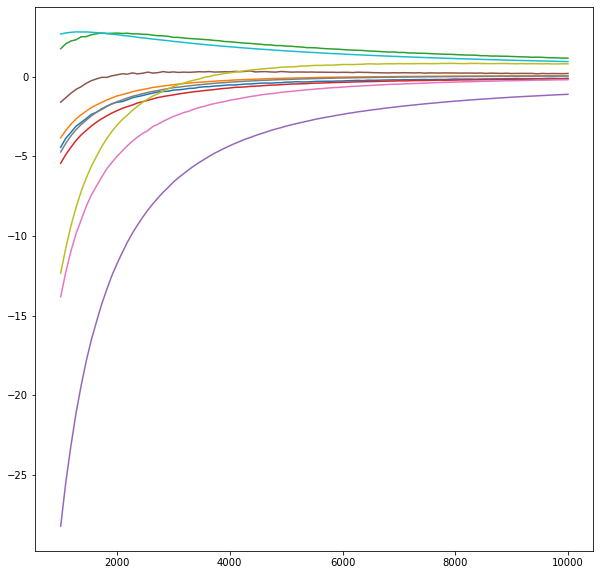

In [279]:
#Hyperparameter optimization.
# We optimize alpha using only the training data (X_train, cog_train)
# https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764

#set hyperparameter grid space you want to search through for the model

# We optimize alpha using only the training data (X_train, cog_train)
# for a detailed description of what is going on in this code:  https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764
#iterate through permutations
p=3
n_cog=2
#joblib-based parallelism to increase speed
with parallel_backend('loky', n_jobs=20):

    #print permutation # you're on
    print('Permutation %d' %(p+1))

    #Splitting the dataset
    x, x_holdout, y, y_holdout = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)
    print("Size of X: " + str(x.shape))
    print("Size of y: " + str(y.shape))

    #set y values for train and test 
    y = y
    y_holdout = y_holdout

    #Scale the data
    scaler = preprocessing.StandardScaler().fit(x)
    x = scaler.transform(x)
    
    #print(x)
    # Initializing Regression models
    regr1= linear_model.Ridge(normalize=True, max_iter=1000000)

    #set the param grid be to the hyperparamters you want to search through
   #set hyperparameter grid space you want to search through for the model
    alphas = np.linspace(1e3, 1e4, num=100, endpoint=True, dtype=None, axis=0)
    
    #set the param grid be to the hyperparamters you want to search through
    paramGrid ={'alpha': alphas}
    
    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=3)
    gridcvs={}
    
    scores = {"R-squared": "r2", "Explained-var": "explained_variance", "MSE":'neg_mean_squared_error'}

    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gcv = GridSearchCV(estimator=regr1,
                           param_grid=paramGrid,
                           scoring=scores,
                           n_jobs=-1,
                           cv=inner_cv,
                           verbose=0,
                           refit="Explained-var")
    gridcvs['Ridge'] = gcv

    best_params=[]
    plt.figure(figsize=(10,10))
    for name, gs_est in sorted(gridcvs.items()):
#
        print(50 * '-', '\n')
        print('Model: ', name)
        print('    Inner loop:')
#
        outer_scores = []
        outer_cv = KFold(n_splits=10, shuffle=True, random_state=3)
        c=1
        bestscore=[]
        for train_idx, test_idx in outer_cv.split(x, y):
 #          print(c)
            c=c+1

            gridcvs[name].fit(x[train_idx], y[train_idx]) # run inner loop hyperparam tuning
            #print('Results:', gridcvs[name].cv_results_)

            print('\n        Best R^2 (avg. of inner test folds) %.2f' % (gridcvs[name].best_score_*100))
            
            print('        Best parameters:', gridcvs[name].best_params_)
            cv_score_val=gridcvs[name].cv_results_['mean_test_Explained-var']*100
            
            plt.plot(np.linspace(1e3,1e4,num=100), gridcvs[name].cv_results_['mean_test_Explained-var']*100)

            
            #plt.plot(gridcvs[name].cv_results_['param_alpha'], grdcvs[name].cv_results_['mean_test_MSE'])
           # ax.set_xticks()
        
            #print(gridcvs[name].cv_results_)
            #save parameters corresponding to the best score
            best_params.append(list(gridcvs[name].best_params_.values()))
            bestscore.append(np.mean(gridcvs[name].best_score_*100))
             # perf on test fold (test_idx)
                
            outer_scores.append(gridcvs[name].best_estimator_.score(x[test_idx], y[test_idx]))
            print('        R^2 (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
            model=gridcvs[name].best_estimator_.fit(x[test_idx], y[test_idx])
            #print(model.coef_)
            #print(demo.columns)

        print('\n    Outer Loop:')
        print('        R^2 %.2f%% +/- %.2f' % 
                  (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))



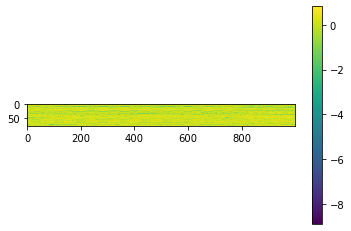

In [133]:
plt.imshow(x[:,1:1000])
plt.colorbar()
plt.show()

In [ ]:
n_cog=1
#joblib-based parallelism to increase speed
with parallel_backend('loky', n_jobs=20):
    
    # iterate through 100 permutations (not necessary
    for p in range(perm):
        
        #print permutation # you're on
        print('Permutation %d' %(p+1))
        
        #Splitting the dataset
        x, x_holdout, y, y_holdout = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)
        print("Size of X: " + str(x.shape))
        print("Size of y: " + str(y.shape))

        #set y values for train and test 
        y = y[:,0]
        y_holdout = y_holdout[:,0]

        #Scale the data
        scaler = preprocessing.StandardScaler().fit(x)
        x = scaler.transform(x)
        pipe = Pipeline([('pca', PCA(n_components=1)), ('regr', linear_model.Ridge(normalize=True, max_iter=1000000))])


        #set the param grid be to the hyperparamters you want to search through
        #set hyperparameter grid space you want to search through for the model
        alphas = np.linspace(1e-3, 1e3, num=100, endpoint=True, dtype=None, axis=0)

        #set the param grid be to the hyperparamters you want to search through
        paramGrid ={'regr__alpha': alphas}
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=3)

        gridcvs={}
        # Setting up multiple GridSearchCV objects, 1 for each algorithm
        gcv = GridSearchCV(estimator=pipe,
                               param_grid=paramGrid,
                               scoring='explained_variance',
                               n_jobs=-1,
                               cv=inner_cv,
                               verbose=0,
                               refit=True)
        gridcvs['Lasso'] = gcv

        # Setting up multiple GridSearchCV objects, 1 for each algorithm
        best_params=[]

        for name, gs_est in sorted(gridcvs.items()):

            print(50 * '-', '\n')
            print('Model: ', name)
            print('    Inner loop:')

            outer_scores = []
            outer_cv = KFold(n_splits=k, shuffle=True, random_state=3)

            for train_idx, test_idx in outer_cv.split(x, y):

                gridcvs[name].fit(x[train_idx], y[train_idx]) # run inner loop hyperparam tuning
                print('\n        Best R^2 (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
                print('        Best parameters:', gridcvs[name].best_params_)
                cv_score_val=gridcvs[name].cv_results_['mean_test_score']

                #save parameters corresponding to the best score
                best_params.append(list(gridcvs[name].best_params_.values()))

                # perf on test fold (test_idx)
                outer_scores.append(gridcvs[name].best_estimator_.score(x[test_idx], y[test_idx]))
                print('        R^2 (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
                model=gridcvs[name].best_estimator_.fit(x[test_idx], y[test_idx])
                #print(model.coef_)
                #print(demo.columns)

            print('\n    Outer Loop:')
            print('        R^2 %.2f%% +/- %.2f' % 
                      (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

        print('\n    Outer Loop:')
        print('        R^2 %.2f%% +/- %.2f' %(np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

        #save optimised alpha values - choose it to be the value corresponding to the median nested score
        #can also use np.max(nested_scores) to choose parameter corresponding to best nested score but might risk overfitting
        print(best_params[outer_scores.index(np.median(outer_scores))][0])
        
        opt_alpha[p]=best_params[outer_scores.index(np.median(outer_scores))][0]
        
        #fit model using optimised hyperparameter
        pca_train = PCA(n_components=1)
        print(x)
        x_pca=pca_train.fit_transform(x)
        
        model = linear_model.Ridge(normalize=False, max_iter=1000000,alpha = opt_alpha[p,0])
        model.fit(x_pca, y);
        
        # transform test data with transformation derived from xtrain
        x_holdout=pca_train.transform(x_holdout)
        print(x_holdout.shape)
        #compute r^2 (coefficient of determination)
        r2[p]=model.score(x_holdout,y_holdout)

        #generate predictions from model
        preds[p] = model.predict(x_holdout)

        #compute explained variance 
        var[p] = explained_variance_score(y_holdout, preds[p,:])

        #compute correlation between true and predicted
        corr[p] = np.corrcoef(y_holdout, preds[p ])[1,0]

        #extract feature importance
        pca_comp[p,:] = pca_train.components_
        featimp[p,:] = model.coef_

Permutation 1
Size of X: (80, 3655)
Size of y: (80, 2)
-------------------------------------------------- 

Model:  Lasso
    Inner loop:

        Best R^2 (avg. of inner test folds) 1.13%
        Best parameters: {'regr__alpha': 0.001}
        R^2 (on outer test fold) 2.86%

        Best R^2 (avg. of inner test folds) -0.01%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -1.16%

        Best R^2 (avg. of inner test folds) -0.00%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -4.68%

        Best R^2 (avg. of inner test folds) 3.37%
        Best parameters: {'regr__alpha': 0.001}
        R^2 (on outer test fold) -84.56%

        Best R^2 (avg. of inner test folds) 9.71%
        Best parameters: {'regr__alpha': 0.001}
        R^2 (on outer test fold) -2.90%

    Outer Loop:
        R^2 -18.09% +/- 33.33

    Outer Loop:
        R^2 -18.09% +/- 33.33
0.001
[[ 0.43551504  0.30367769  0.43844239 ...  0.35057862  0.376537


        Best R^2 (avg. of inner test folds) -0.00%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -0.04%

        Best R^2 (avg. of inner test folds) -0.00%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -13.80%

        Best R^2 (avg. of inner test folds) -0.01%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -64.93%

        Best R^2 (avg. of inner test folds) -0.01%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -15.89%

        Best R^2 (avg. of inner test folds) -0.01%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -1.66%

    Outer Loop:
        R^2 -19.26% +/- 23.69

    Outer Loop:
        R^2 -19.26% +/- 23.69
1000.0
[[0.38923089 0.40586162 0.38357655 ... 0.38066603 0.39613201 0.43009275]
 [0.38902059 0.32720832 0.26681487 ... 0.38066603 0.39613201 0.43009275]
 [0.38923089 0.40586162 0.38357655 ... 0.3806


        Best R^2 (avg. of inner test folds) -0.00%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -2.77%

        Best R^2 (avg. of inner test folds) -0.00%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -0.57%

        Best R^2 (avg. of inner test folds) 0.03%
        Best parameters: {'regr__alpha': 10.102}
        R^2 (on outer test fold) -0.22%

        Best R^2 (avg. of inner test folds) 1.06%
        Best parameters: {'regr__alpha': 0.001}
        R^2 (on outer test fold) -59.90%

        Best R^2 (avg. of inner test folds) -0.00%
        Best parameters: {'regr__alpha': 1000.0}
        R^2 (on outer test fold) -0.50%

    Outer Loop:
        R^2 -12.79% +/- 23.57

    Outer Loop:
        R^2 -12.79% +/- 23.57
1000.0
[[-0.19362477 -3.87440543 -3.64919911 ...  0.37330007  0.41006112
   0.45801338]
 [ 0.44264121  0.4348067   0.45942248 ...  0.37330007  0.41006112
   0.45801366]
 [ 0.08804496  0.34648615  0.43368

In [239]:
np.set_printoptions(threshold=True)

In [87]:
np.savetxt(results_dir+'fc_demo_dmemfu1_r2.txt', r2, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_var.txt', var, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_corr.txt', corr, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_alpha.txt', opt_alpha, delimiter=',')

np.savetxt(results_dir+'fc_demo_dmemfu1_featimp.txt', featimp, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_preds.txt', preds, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_cogtest.txt', cogtest, delimiter=',')


In [88]:
A = np.zeros([perm,n_feat])

#iterate through permutations
for p in range(perm):
    print('Permutation %d' %(p+1))

    cov_x= np.zeros([n_feat])
    x_train, x_test, cog_train, cog_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)

    #compute covariance of training X data
    cov_x = np.cov(np.transpose(x_train))

    #for each of the cognitive scores
    for i in range(n_cog):
        #compute covariance of training cognitive scores
        cov_y = np.cov(cog_train[:,i])
        #compute activation vector by matrix multiplying training X covariance, feature weights, and 1/training Y covariance 
        A[p,:] = np.matmul(cov_x,featimp[p,:])*(1/cov_y)


A_avg = np.mean(A,axis=0)
np.savetxt(results_dir+'fc_demo_demo_dmemorig_featimpA_dmemfu1.txt', A_avg, delimiter=',')

Permutation 1
Permutation 2
Permutation 3
Permutation 4
Permutation 5
Permutation 6
Permutation 7
Permutation 8
Permutation 9
Permutation 10
Permutation 11
Permutation 12
Permutation 13
Permutation 14
Permutation 15
Permutation 16
Permutation 17
Permutation 18
Permutation 19
Permutation 20
Permutation 21
Permutation 22
Permutation 23
Permutation 24
Permutation 25
Permutation 26
Permutation 27
Permutation 28
Permutation 29
Permutation 30
Permutation 31
Permutation 32
Permutation 33
Permutation 34
Permutation 35
Permutation 36
Permutation 37
Permutation 38
Permutation 39
Permutation 40
Permutation 41
Permutation 42
Permutation 43
Permutation 44
Permutation 45
Permutation 46
Permutation 47
Permutation 48
Permutation 49
Permutation 50
Permutation 51
Permutation 52
Permutation 53
Permutation 54
Permutation 55
Permutation 56
Permutation 57
Permutation 58
Permutation 59
Permutation 60
Permutation 61
Permutation 62
Permutation 63
Permutation 64
Permutation 65
Permutation 66
Permutation 67
Perm